In [1]:
import sys
import multiprocessing
sys.path.append('..')
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from lib.lanutils.fs.indices import get_indices
%matplotlib inline

In [2]:
class BlackMarginCrop(object):
    def __init__(self, *, thresh=1, **kwargs):
        """
        :param thresh: used to determine the binary image, i.e. pixel value lt thresh goes to 0
        """
        self.thresh = thresh

    def __call__(self, im):
        left = top = 0
        h, w = im.shape[:2]
        right, bottom = w - 1, h - 1
        im_grayscale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        if im_grayscale.sum() == 0:
            raise ValueError("Encountered pure black image. ")
        im_grayscale[im_grayscale < self.thresh] = 0
        squashed_row = im_grayscale.sum(axis=0)
        squashed_col = im_grayscale.sum(axis=1)
        row_nonzero = (squashed_row / h > 0.1).nonzero()[0]
        col_nonzero = (squashed_col / w > 0.1).nonzero()[0]
        if len(row_nonzero) > 0:
            left, right = row_nonzero[0], row_nonzero[-1]
        if len(col_nonzero) > 0:
            top, bottom = col_nonzero[0], col_nonzero[-1]
        return im[top:bottom+1, left:right+1].copy()


def get_crop_resized_imgs(file_index):
    im_path = args.dataset_dir / f"{file_index}{args.im_suffix}"
    im = cv2.imread(str(im_path))
    im = BlackMarginCrop(thresh=15)(im)
    im = cv2.resize(im, (224, 224))
    return im


def calc_hist(ims, density=False, min_value=6):
    pix_by_channel = np.array(ims).transpose(3, 1, 2, 0).reshape(3, -1)
    hist = [np.histogram(c, bins=255-min_value, density=density, range=(min_value, 255))[0] for c in pix_by_channel]
    return hist

In [44]:
class APTOS2019_ARGS:
    dataset_dir = Path("/data2/datasets/kaggle/blindness-detection-aptos2019/typical-images")
    im_suffix = ".png"
    num_processes = 10
    min_value = 6
    
    def __getattr__(self, name):
        return


class BlindnessDetection2015_ARGS:
    dataset_dir = Path("/data2/datasets/kaggle/diabetic-retinopathy-detection-2015/raw/train")
    random_sample = 100
    im_suffix = ".jpeg"
    num_processes = 10
    min_value = 6
    
    def __getattr__(self, name):
        return

In [4]:
args = APTOS2019_ARGS()
indices = get_indices(args.indices, args.dataset_dir, args.im_suffix, random_sample=args.random_sample)
if args.num_processes == 0:
    ims = [get_crop_resized_imgs(ind) for ind in tqdm(indices)]
else:
    with multiprocessing.Pool(processes=args.num_processes) as pool:
        ims = list(tqdm(pool.imap_unordered(get_crop_resized_imgs, indices), total=len(indices)))
density = calc_hist(ims, density=True, min_value=args.min_value)

100%|██████████| 186/186 [00:00<00:00, 4657.00it/s]


<BarContainer object of 249 artists>

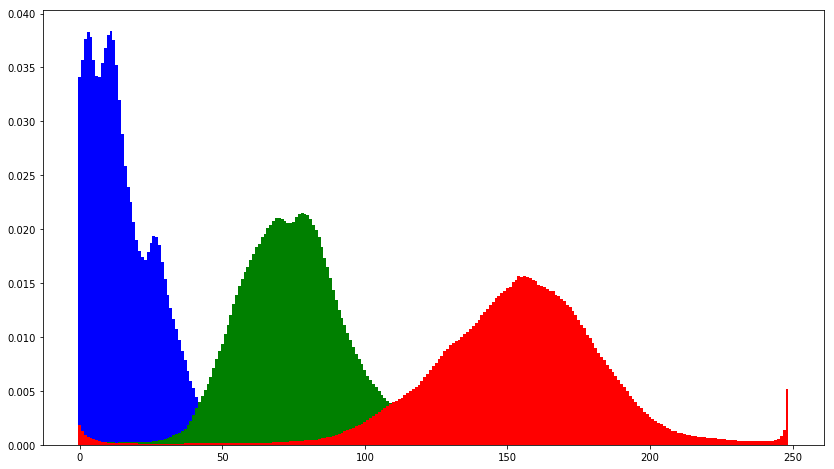

In [5]:
plt.figure(figsize=(14, 8))
plt.bar(np.arange(255 - args.min_value), density[0], width=1, color='b')
plt.bar(np.arange(255 - args.min_value), density[1], width=1, color='g')
plt.bar(np.arange(255 - args.min_value), density[2], width=1, color='r')

In [45]:
args = BlindnessDetection2015_ARGS()
indices = get_indices(args.indices, args.dataset_dir, args.im_suffix, random_sample=args.random_sample)
if args.num_processes == 0:
    ims = [get_crop_resized_imgs(ind) for ind in tqdm(indices)]
else:
    with multiprocessing.Pool(processes=args.num_processes) as pool:
        ims = list(tqdm(pool.imap_unordered(get_crop_resized_imgs, indices), total=len(indices)))

100%|██████████| 100/100 [00:01<00:00, 62.81it/s]


In [50]:
def get_density_mean(density_channel):
#     return np.argmax(density_channel)
    return (np.cumsum(density_channel) - 0.5 > 0).nonzero()[0][0]


def similar_to_2019(density):
    red_mean = get_density_mean(density[2])
    green_mean = get_density_mean(density[1])
    blue_mean = get_density_mean(density[0])
    return 110 < red_mean < 210 and 40 < green_mean < 100 and blue_mean < 60 and 20 < red_mean - green_mean < 80 and 10 < green_mean - blue_mean < 50

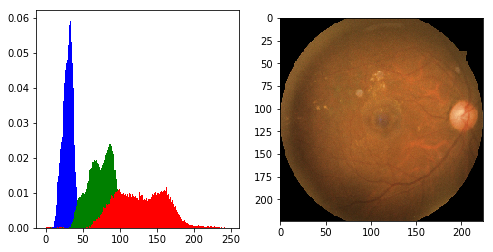

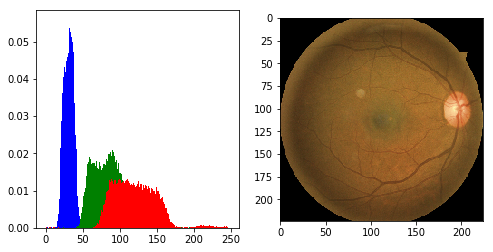

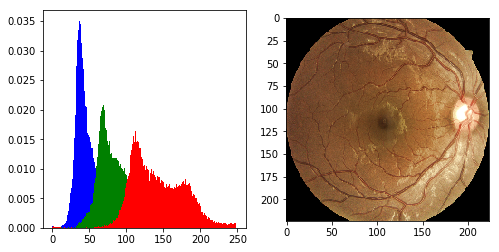

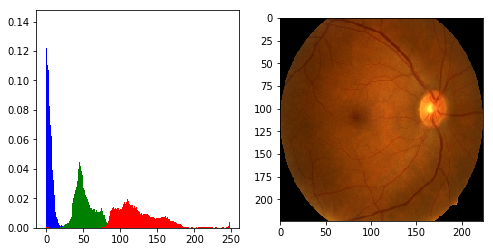

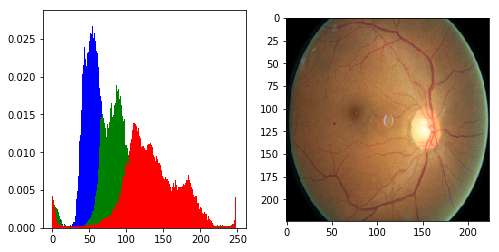

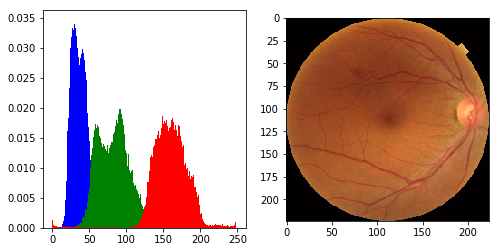

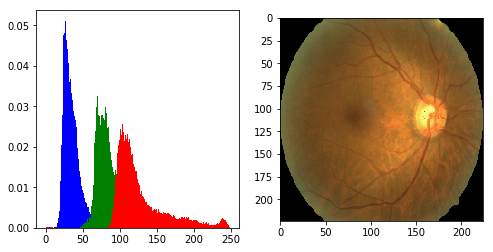

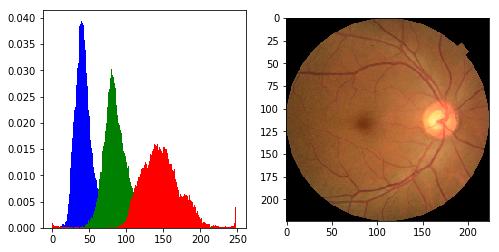

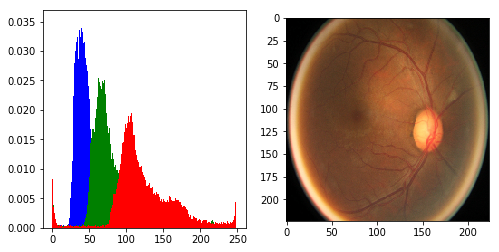

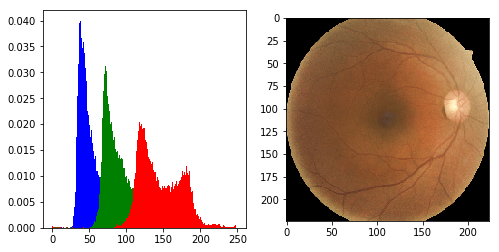

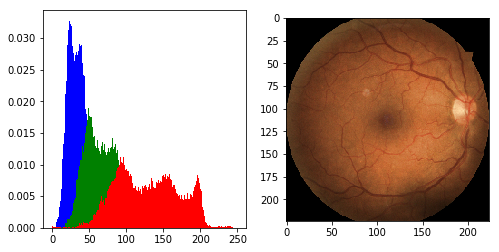

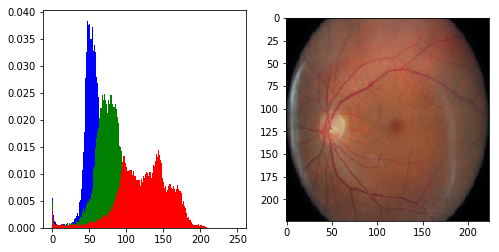

In [51]:
for i in range(len(ims)):
    density = calc_hist(ims[i:i+1], density=True, min_value=args.min_value)
    if similar_to_2019(density):
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.bar(np.arange(255 - args.min_value), density[0], width=1, color='b')
        plt.bar(np.arange(255 - args.min_value), density[1], width=1, color='g')
        plt.bar(np.arange(255 - args.min_value), density[2], width=1, color='r')
    #     density = calc_hist(linear_stretch(ims[i].copy())[None], density=True, min_value=args.min_value)
    #     plt.imshow(linear_stretch(ims[i].copy())[..., ::-1])
        plt.subplot(122)
        plt.imshow(ims[i][..., ::-1])
    